In [1]:
import os
os.chdir('../..')
!ls

product_impacts


python(10795) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [2]:
import os.path
import pandas as pd
from skimpy import skim
import requests
from bs4 import BeautifulSoup
import statistics
from sentence_transformers import SentenceTransformer, util
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, mean_squared_error, r2_score, roc_auc_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
from hiclass import LocalClassifierPerParentNode, LocalClassifierPerLevel

from product_impacts.product_cat.run_model import get_store, get_ndns_cats, get_products, get_ndns_matches, get_tsne

import numpy as np
import pickle
import json

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

sns.set()

python(10845) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
os.environ["RAY_ENABLE_MAC_LARGE_OBJECT_STORE"] = "1"

In [5]:
ndns = get_ndns_cats('../../SFS/NDNS UK/ndns_edited.csv')
products = get_products()
labelled_data, non_food_products = get_ndns_matches(
    ndns, products)

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [6]:
# removing duplicated product names + ingredients (basically products with same exact feature vectors)
labelled_data['product_list_name_lower'] = labelled_data['product_list_name'].str.lower()
labelled_data['ingredients_text_lower'] = labelled_data['ingredients_text'].str.lower()
labelled_data = labelled_data.drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

In [7]:
# lev 0 predictions
predicted_data = pd.read_csv('../../SFS/NDNS UK/predictions/predictions_lev0_manuallabels_nonHI_RF_withcorrections_14Oct2024.csv')

In [8]:
predicted_data.shape

(262711, 11)

In [9]:
predicted_data['parentcategory_pred'].value_counts()

Cereals and Cereal Products             52426
Miscellaneous                           27598
Meat and Meat Products                  26837
Non-Alcoholic Beverages                 25994
Sugar, Preserves and Confectionery      25822
Vegetables, Potatoes                    23757
Milk and Milk Products                  23239
Alcoholic Beverages                     15150
Fish and Fish Dishes                     9302
Fruit                                    7343
Savoury Snacks                           6460
Not Food                                 5086
Nuts and Seeds                           5057
Fat Spreads                              3811
Commercial Toddlers Foods and Drinks     2488
Eggs and Egg Dishes                      1315
Dietary Supplements                       622
Artificial Sweeteners                     404
Name: parentcategory_pred, dtype: int64

In [10]:
pred = predicted_data[predicted_data['parentcategory_pred']=='Meat and Meat Products'].reset_index(drop=True)
lab = labelled_data[(labelled_data['parentcategory']=='Meat and Meat Products')
                           & (labelled_data['subfoodgroupdesc'].notnull())].reset_index(drop=True)
lab = lab.merge(pred[['product_id']])

In [11]:
pred.shape

(26837, 11)

In [12]:
lab.shape

(6461, 12)

In [13]:
lab['subfoodgroupdesc'].value_counts()

Other chicken and turkey                       1750
Bacon and ham                                   916
Beef and veal                                   820
Sausages                                        579
Manufactured coated chicken/turkey products     541
Meat pies and pastries                          517
Other meat products                             405
Burgers and kebabs purchased                    306
Pork                                            290
Lamb                                            289
Liver and dishes                                 48
Name: subfoodgroupdesc, dtype: int64

In [14]:
lab['mainfoodgroupdesc'].value_counts()

Chicken and turkey dishes                 1750
Bacon and ham                              916
Beef, veal and dishes                      820
Sausages                                   579
Coated chicken and turkey manufactured     541
Meat pies and pastries                     517
Other meat and meat products               405
Burgers and kebabs                         306
Pork and dishes                            290
Lamb and dishes                            289
Liver, products and dishes                  48
Name: mainfoodgroupdesc, dtype: int64

In [15]:
pred['subfoodgroup_lab'].value_counts()

Other chicken and turkey                             1755
Bacon and ham                                         921
Beef and veal                                         831
Sausages                                              581
Manufactured coated chicken/turkey products           541
Meat pies and pastries                                517
Other meat products                                   408
Burgers and kebabs purchased                          306
Pork                                                  299
Lamb                                                  293
Liver and dishes                                       48
Pasta                                                  34
Crisps and savoury snacks                              17
Rice                                                   16
Pizza                                                  10
Buns cakes and pastries                                 8
Savoury sauces pickles gravies & condiments             7
Other bread   

In [16]:
# correcting some labels

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains('peperami'))
        & (lab['product_list_name'].str.lower().str.contains('chicken')),
        'subfoodgroupdesc'] = 'Other chicken and turkey'

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains('corned beef')),
        'subfoodgroupdesc'] = 'Beef and veal'

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains('peperami'))
        & (lab['product_list_name'].str.lower().str.contains('beef')),
        'subfoodgroupdesc'] = 'Beef and veal'

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains('cured meat'))
        & (lab['product_list_name'].str.lower().str.contains('italian')),
        'subfoodgroupdesc'] = 'Beef and veal'

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains('antipasto'))
        & (lab['product_list_name'].str.lower().str.contains('m&s italian')),
        'subfoodgroupdesc'] = 'Beef and veal'

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains('bresaola')),
        'subfoodgroupdesc'] = 'Beef and veal'

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains('chorizo')),
        'subfoodgroupdesc'] = 'Sausages'

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains('cured meat'))
        & (lab['product_list_name'].str.lower().str.contains('italian')),
        'subfoodgroupdesc'] = 'Sausages'

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains('saucisson')),
        'subfoodgroupdesc'] = 'Sausages'

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains('salami')),
        'subfoodgroupdesc'] = 'Sausages'

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains('pepperoni')),
        'subfoodgroupdesc'] = 'Sausages'

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains('sausage')),
        'subfoodgroupdesc'] = 'Sausages'

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains('nduja')),
        'subfoodgroupdesc'] = 'Sausages'

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains('frankfurters')),
        'subfoodgroupdesc'] = 'Sausages'

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains('peperami'))
        & (~lab['product_list_name'].str.lower().str.contains('beef'))
        & (~lab['product_list_name'].str.lower().str.contains('chicken')),
        'subfoodgroupdesc'] = 'Sausages'

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains('charcuterie')),
        'subfoodgroupdesc'] = 'Bacon and ham'

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains('antipasto'))
        & (~lab['product_list_name'].str.lower().str.contains('m&s italian')),
        'subfoodgroupdesc'] = 'Bacon and ham'

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains('pancetta')),
        'subfoodgroupdesc'] = 'Bacon and ham'

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains('guanciale')),
        'subfoodgroupdesc'] = 'Bacon and ham'

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains('jamon')),
        'subfoodgroupdesc'] = 'Bacon and ham'

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains('jambon')),
        'subfoodgroupdesc'] = 'Bacon and ham'

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains(' ham')),
        'subfoodgroupdesc'] = 'Bacon and ham'

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains('proscuitto')),
        'subfoodgroupdesc'] = 'Bacon and ham'

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains('pork'))
        & (~lab['product_list_name'].str.lower().str.contains('tongue'))
        & (~lab['product_list_name'].str.lower().str.contains('luncheon'))
        & (~lab['product_list_name'].str.lower().str.contains('faggots'))
        & (~lab['product_list_name'].str.lower().str.contains('ham'))
        & (~lab['product_list_name'].str.lower().str.contains('saucisson'))
        & (~lab['product_list_name'].str.lower().str.contains('kidney')),
        'subfoodgroupdesc'] = 'Pork'

lab.loc[(lab['subfoodgroupdesc']=='Other meat products')
        & (lab['product_list_name'].str.lower().str.contains('capocollo')),
        'subfoodgroupdesc'] = 'Pork'

lab.loc[(lab['subfoodgroupdesc']=='Beef and veal')
        & (lab['product_list_name'].str.lower().str.contains('venison')),
        'subfoodgroupdesc'] = 'Other meat products'

In [17]:
# correcting the lev 1 categories and codes
lab = lab.drop(['mainfoodgroupcode', 'mainfoodgroupdesc', 'subfoodgroupcode'], axis=1)
lab = lab.merge(
    ndns[['mainfoodgroupcode', 'mainfoodgroupdesc', 'subfoodgroupcode', 'subfoodgroupdesc']].drop_duplicates(
        subset=['subfoodgroupdesc']), how='left')

In [18]:
lab['subfoodgroupdesc'].value_counts()

Other chicken and turkey                       1755
Bacon and ham                                   957
Beef and veal                                   905
Sausages                                        728
Manufactured coated chicken/turkey products     541
Meat pies and pastries                          517
Burgers and kebabs purchased                    306
Pork                                            297
Lamb                                            289
Other meat products                             118
Liver and dishes                                 48
Name: subfoodgroupdesc, dtype: int64

In [19]:
lab['mainfoodgroupdesc'].value_counts()

Chicken and turkey dishes                 1755
Bacon and ham                              957
Beef, veal and dishes                      905
Sausages                                   728
Coated chicken and turkey manufactured     541
Meat pies and pastries                     517
Burgers and kebabs                         306
Pork and dishes                            297
Lamb and dishes                            289
Other meat and meat products               118
Liver, products and dishes                  48
Name: mainfoodgroupdesc, dtype: int64

In [20]:
lev2_labels_add = pred[[
    'product_id', 'product_list_name', 'product_name', 'ingredients_text', 'store']]
lev2_labels_add['parentcategory'] = 'Meat and Meat Products'
lev2_labels_add['subfoodgroupdesc'] = np.NaN


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("lily's kitchen")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("dog food")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cat food")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("dog treats")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("chunks in jelly")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("hilife")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("good boy")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("healthy paws")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("carnilove")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("small animal")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("hedgehog food")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("puppy training treats")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("naturally adult cat")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("kings wagyu")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("venison"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("steak")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("shredded duck")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("duck rolls")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("venison with plum")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("venison steak")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("venison loin steak")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("duck & wild boar")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("rack of venison")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("guinea fowl")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("whole duck")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("gourmet duck & venison")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("confit duck")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("duck spring roll")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("duck legs")),
                    'subfoodgroupdesc'] = 'Other meat products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("haggis")),
                    'subfoodgroupdesc'] = 'Other meat products'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("beef pasties")),
                    'subfoodgroupdesc'] = 'Meat pies and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cottage pie")),
                    'subfoodgroupdesc'] = 'Meat pies and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("creamy chicken bakes")),
                    'subfoodgroupdesc'] = 'Meat pies and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("lamb filo pie ")),
                    'subfoodgroupdesc'] = 'Meat pies and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains(" tart")),
                    'subfoodgroupdesc'] = 'Meat pies and pastries'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("taste the difference chicken")),
                    'subfoodgroupdesc'] = 'Other chicken and turkey'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("turkey rashers")),
                    'subfoodgroupdesc'] = 'Other chicken and turkey'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("bentos meatballs")),
                    'subfoodgroupdesc'] = 'Other chicken and turkey'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("coq au vin")),
                    'subfoodgroupdesc'] = 'Other chicken and turkey'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("chicken lasagne")),
                    'subfoodgroupdesc'] = 'Other chicken and turkey'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("turkey burger"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("crumb")),
                    'subfoodgroupdesc'] = 'Other chicken and turkey'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("bernard matthews turkey"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("slices")),
                    'subfoodgroupdesc'] = 'Other chicken and turkey'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("bernard matthews turkey"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("chunks")),
                    'subfoodgroupdesc'] = 'Other chicken and turkey'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("coronation chicken sandwich")),
                    'subfoodgroupdesc'] = 'Other chicken and turkey'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("chicken bacon & lettuce sandwich")),
                    'subfoodgroupdesc'] = 'Other chicken and turkey'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("bbq chicken wrap")),
                    'subfoodgroupdesc'] = 'Other chicken and turkey'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("chicken & sweetcorn sandwich")),
                    'subfoodgroupdesc'] = 'Other chicken and turkey'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("chicken & maple cured bacon sandwich")),
                    'subfoodgroupdesc'] = 'Other chicken and turkey'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("chicken & cheese snack wrap")),
                    'subfoodgroupdesc'] = 'Other chicken and turkey'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("crown of turkey & duck")),
                    'subfoodgroupdesc'] = 'Other chicken and turkey'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("medium turkey crown")),
                    'subfoodgroupdesc'] = 'Other chicken and turkey'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("turkey meatballs")),
                    'subfoodgroupdesc'] = 'Other chicken and turkey'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("itsu chicken gyoza")),
                    'subfoodgroupdesc'] = 'Other chicken and turkey'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("poussin")),
                    'subfoodgroupdesc'] = 'Other chicken and turkey'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("chicken salad")),
                    'subfoodgroupdesc'] = 'Other chicken and turkey'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("spicy chicken grills")),
                    'subfoodgroupdesc'] = 'Manufactured coated chicken/turkey products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("southern fried chicken")),
                    'subfoodgroupdesc'] = 'Manufactured coated chicken/turkey products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("spicy chicken breast")),
                    'subfoodgroupdesc'] = 'Manufactured coated chicken/turkey products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("turkey burger"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("crumb")),
                    'subfoodgroupdesc'] = 'Manufactured coated chicken/turkey products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("pep'd up chicken")),
                    'subfoodgroupdesc'] = 'Manufactured coated chicken/turkey products'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("chicken burgers")),
                    'subfoodgroupdesc'] = 'Manufactured coated chicken/turkey products'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("ardennes")),
                    'subfoodgroupdesc'] = 'Liver and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("duck parfait")),
                    'subfoodgroupdesc'] = 'Liver and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("liver & bacon")),
                    'subfoodgroupdesc'] = 'Liver and dishes'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("beef burrito")),
                    'subfoodgroupdesc'] = 'Beef and veal'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("roast peppered beef")),
                    'subfoodgroupdesc'] = 'Beef and veal'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("negroni bresaola")),
                    'subfoodgroupdesc'] = 'Beef and veal'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("angus beef steak")),
                    'subfoodgroupdesc'] = 'Beef and veal'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("original beef jerky")),
                    'subfoodgroupdesc'] = 'Beef and veal'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("boneless beef ribs")),
                    'subfoodgroupdesc'] = 'Beef and veal'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("beef meatball")),
                    'subfoodgroupdesc'] = 'Beef and veal'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("beef short rib")),
                    'subfoodgroupdesc'] = 'Beef and veal'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("korean style beef")),
                    'subfoodgroupdesc'] = 'Beef and veal'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("veal"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("burger"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("liver"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains(" cat ")),
                    'subfoodgroupdesc'] = 'Beef and veal'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cooked pork belly")),
                    'subfoodgroupdesc'] = 'Pork'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("unsmoked rashers")),
                    'subfoodgroupdesc'] = 'Pork'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("value rashers")),
                    'subfoodgroupdesc'] = 'Pork'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("pulled pork")),
                    'subfoodgroupdesc'] = 'Pork'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("pork and stuffing roll")),
                    'subfoodgroupdesc'] = 'Pork'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("wassailing stuffing")),
                    'subfoodgroupdesc'] = 'Pork'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("pork & lentil ragu")),
                    'subfoodgroupdesc'] = 'Pork'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("ready to cook pork")),
                    'subfoodgroupdesc'] = 'Pork'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("denny cap rsher")),
                    'subfoodgroupdesc'] = 'Pork'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("pork and egg roll")),
                    'subfoodgroupdesc'] = 'Pork'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("rustlers microwave bbq rib")),
                    'subfoodgroupdesc'] = 'Pork'

lab.loc[(lab['product_list_name'].str.lower().str.contains("vinegar flavoured pork cr")),
                    'subfoodgroupdesc'] = 'Pork'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("smoked pork belly")),
                    'subfoodgroupdesc'] = 'Pork'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("saucisson")),
                    'subfoodgroupdesc'] = 'Pork'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("pork & egg")),
                    'subfoodgroupdesc'] = 'Pork'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("sliced pancetta")),
                    'subfoodgroupdesc'] = 'Bacon and ham'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("diced pancetta")),
                    'subfoodgroupdesc'] = 'Bacon and ham'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("smoked pancetta")),
                    'subfoodgroupdesc'] = 'Bacon and ham'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("italian pancetta")),
                    'subfoodgroupdesc'] = 'Bacon and ham'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("sliced antipasto selection")),
                    'subfoodgroupdesc'] = 'Bacon and ham'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("italian antipasto selection")),
                    'subfoodgroupdesc'] = 'Bacon and ham'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("spanish chorizo")),
                    'subfoodgroupdesc'] = 'Sausages'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("chorizo picante")),
                    'subfoodgroupdesc'] = 'Sausages'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("m&s chorizo")),
                    'subfoodgroupdesc'] = 'Sausages'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("spicy chorizo")),
                    'subfoodgroupdesc'] = 'Sausages'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("breakfast sausage")),
                    'subfoodgroupdesc'] = 'Sausages'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cured mortadella")),
                    'subfoodgroupdesc'] = 'Sausages'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("berlinki classic")),
                    'subfoodgroupdesc'] = 'Sausages'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("classic frankfurters")),
                    'subfoodgroupdesc'] = 'Sausages'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("the full monty")),
                    'subfoodgroupdesc'] = 'Sausages'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("rustlers hot dog")),
                    'subfoodgroupdesc'] = 'Sausages'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("pigs in blankets")),
                    'subfoodgroupdesc'] = 'Sausages'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("chorizo style")),
                    'subfoodgroupdesc'] = 'Sausages'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("chorizo & gouda")),
                    'subfoodgroupdesc'] = 'Sausages'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("lamb meatball")),
                    'subfoodgroupdesc'] = 'Lamb'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("lamb"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("kebab")),
                    'subfoodgroupdesc'] = 'Burgers and kebabs purchased'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("charcoal"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("kebab")),
                    'subfoodgroupdesc'] = 'Burgers and kebabs purchased'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("humza meat kebab")),
                    'subfoodgroupdesc'] = 'Burgers and kebabs purchased'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("lamb shish kebabs")),
                    'subfoodgroupdesc'] = 'Burgers and kebabs purchased'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("liver & bacon")),
                    'subfoodgroupdesc'] = 'Burgers and kebabs purchased'

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A val

In [21]:
# lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("venison steak"))
#                    ]

In [22]:
lev2_labels_add = lev2_labels_add.merge(
    ndns.drop('detaileddesc', axis=1)).drop_duplicates(subset=['product_id', 'subfoodgroupdesc'])
lev2_labels_add['product_list_name_lower'] = lev2_labels_add['product_list_name'].str.lower()
lev2_labels_add['ingredients_text_lower'] = lev2_labels_add['ingredients_text'].str.lower()
lev2_labels_add = lev2_labels_add.drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

dups = lab[['product_id', 'product_list_name_lower', 'ingredients_text_lower', 'subfoodgroupdesc']].merge(
    lev2_labels_add[['product_list_name_lower', 'ingredients_text_lower', 'subfoodgroupdesc']])['product_id'].values
lev2_labels_add = lev2_labels_add[(~lev2_labels_add['product_id'].isin(dups))]
lab = lab[(~lab['product_id'].isin(lev2_labels_add['product_id'].values))]
lab = pd.concat([lab, lev2_labels_add], ignore_index=True, axis=0).drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

In [23]:
lab.shape

(8679, 12)

In [24]:
lab['subfoodgroupdesc'].value_counts()

Other chicken and turkey                       1838
Other meat products                            1409
Bacon and ham                                   999
Beef and veal                                   955
Sausages                                        856
Manufactured coated chicken/turkey products     756
Meat pies and pastries                          741
Pork                                            405
Burgers and kebabs purchased                    347
Lamb                                            287
Liver and dishes                                 86
Name: subfoodgroupdesc, dtype: int64

In [25]:
pred = pred.drop('mainfoodgroup_lab', axis=1).merge(
    lab[['product_id', 'mainfoodgroupdesc']], how='left').rename(columns={'mainfoodgroupdesc': 'mainfoodgroup_lab'})

pred = pred.drop('subfoodgroup_lab', axis=1).merge(
    lab[['product_id', 'subfoodgroupdesc']], how='left').rename(columns={'subfoodgroupdesc': 'subfoodgroup_lab'})

In [26]:
query_embeddings = np.load('../../SFS/bert/all_embeddings_all3.npy')
tsne_results = get_tsne(query_embeddings, '../../SFS/bert/tsne_results_all3.npy')
product_ids = np.load('../../SFS/bert/all_ids_all3.npy')

features = pd.DataFrame(data=query_embeddings)
id_col = 'product_id'
X_cols = features.columns.tolist()
y_cols = ['parentcategory', 'mainfoodgroupdesc', 'subfoodgroupdesc']

features['product_id'] = pd.Series(product_ids, index=features.index)
features[['tsne_0', 'tsne_1']] = tsne_results
lab = lab.merge(features)

In [27]:
acc_list_train = []
bal_acc_list_train = []
precision_list_train = []
recall_list_train = []
f1_list_train = []
mcc_list_train = []

acc_list_test = []
bal_acc_list_test = []
precision_list_test = []
recall_list_test = []
f1_list_test = []
mcc_list_test = []

for i in range(1):
    train, test = train_test_split(lab, test_size=0.2, random_state=i)
    print(f'Number of unique level 1 categories in train: {train[y_cols[1]].nunique()}')
    print(f'Number of unique level 1 categories in test: {test[y_cols[1]].nunique()}')
    print(f'Number of unique level 2 categories in train: {train[y_cols[2]].nunique()}')
    print(f'Number of unique level 2 categories in test: {test[y_cols[2]].nunique()}\n')

    X_train = train[X_cols]
    y_train = train[[y_cols[1], y_cols[2]]]
    y_train1 = train[y_cols[1]]
    y_train2 = train[y_cols[2]]

    X_test = test[X_cols]
    y_test = test[[y_cols[1], y_cols[2]]]
    y_test1 = test[y_cols[1]]
    y_test2 = test[y_cols[2]]

    mod = RandomForestClassifier(n_estimators=400, 
                                 min_samples_leaf=10, 
                                 max_depth=25,
                                 class_weight='balanced'
                                )

    clf2 = mod
    clf2.fit(X_train, y_train2)
    y_train_pred2 = clf2.predict(X_train)
    y_test_pred2 = clf2.predict(X_test)

    y_train_pred1 = pd.DataFrame(y_train_pred2, columns=[y_cols[2]]).merge(
        lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values
    y_test_pred1 = pd.DataFrame(y_test_pred2, columns=[y_cols[2]]).merge(
        lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values

    print(f'Lev 1 train accuracy: {accuracy_score(y_train1, y_train_pred1)}')
    print(f'Lev 1 train balanced accuracy: {balanced_accuracy_score(y_train1, y_train_pred1)}')
    print(f'Lev 1 test accuracy: {accuracy_score(y_test1, y_test_pred1)}')
    print(f'Lev 1 test balanced accuracy: {balanced_accuracy_score(y_test1, y_test_pred1)}\n')

    print(f'Lev 2 train accuracy: {accuracy_score(y_train2, y_train_pred2)}')
    print(f'Lev 2 train balanced accuracy: {balanced_accuracy_score(y_train2, y_train_pred2)}')
    print(f'Lev 2 test accuracy: {accuracy_score(y_test2, y_test_pred2)}')
    print(f'Lev 2 test balanced accuracy: {balanced_accuracy_score(y_test2, y_test_pred2)}\n')

    print(f'Number of unique level 1 categories predicted in train: {len(np.unique(y_train_pred1))}')
    print(f'Number of unique level 1 categories predicted in test: {len(np.unique(y_test_pred1))}')    
    print(f'Number of unique level 2 categories predicted in train: {len(np.unique(y_train_pred2))}')
    print(f'Number of unique level 2 categories predicted in test: {len(np.unique(y_test_pred2))}\n')    
    
    acc_list_train.append(accuracy_score(y_train2, y_train_pred2))
    bal_acc_list_train.append(balanced_accuracy_score(y_train2, y_train_pred2))
    precision_list_train.append(precision_score(y_train2, y_train_pred2, average='weighted'))
    recall_list_train.append(recall_score(y_train2, y_train_pred2, average='weighted'))
    f1_list_train.append(f1_score(y_train2, y_train_pred2, average='weighted'))
    mcc_list_train.append(matthews_corrcoef(y_train2, y_train_pred2))
    
    acc_list_test.append(accuracy_score(y_test2, y_test_pred2))
    bal_acc_list_test.append(balanced_accuracy_score(y_test2, y_test_pred2))
    precision_list_test.append(precision_score(y_test2, y_test_pred2, average='weighted'))
    recall_list_test.append(recall_score(y_test2, y_test_pred2, average='weighted'))
    f1_list_test.append(f1_score(y_test2, y_test_pred2, average='weighted'))
    mcc_list_test.append(matthews_corrcoef(y_test2, y_test_pred2))

Number of unique level 1 categories in train: 11
Number of unique level 1 categories in test: 11
Number of unique level 2 categories in train: 11
Number of unique level 2 categories in test: 11

Lev 1 train accuracy: 0.970041768687887
Lev 1 train balanced accuracy: 0.9778862735839468
Lev 1 test accuracy: 0.9245391705069125
Lev 1 test balanced accuracy: 0.926938829876433

Lev 2 train accuracy: 0.970041768687887
Lev 2 train balanced accuracy: 0.9778862735839465
Lev 2 test accuracy: 0.9245391705069125
Lev 2 test balanced accuracy: 0.926938829876433

Number of unique level 1 categories predicted in train: 11
Number of unique level 1 categories predicted in test: 11
Number of unique level 2 categories predicted in train: 11
Number of unique level 2 categories predicted in test: 11



In [28]:
print('train')
print(f'accuracy: {statistics.mean(acc_list_train)}')
print(f'balanced accuracy: {statistics.mean(bal_acc_list_train)}')
print(f'precision: {statistics.mean(precision_list_train)}')
print(f'recall: {statistics.mean(recall_list_train)}')
print(f'f1: {statistics.mean(f1_list_train)}')
print(f'mcc: {statistics.mean(mcc_list_train)}')

print('test')
print(f'accuracy: {statistics.mean(acc_list_test)}')
print(f'balanced accuracy: {statistics.mean(bal_acc_list_test)}')
print(f'precision: {statistics.mean(precision_list_test)}')
print(f'recall: {statistics.mean(recall_list_test)}')
print(f'f1: {statistics.mean(f1_list_test)}')
print(f'mcc: {statistics.mean(mcc_list_test)}')

train
accuracy: 0.970041768687887
balanced accuracy: 0.9778862735839465
precision: 0.9708441810554057
recall: 0.970041768687887
f1: 0.9700947003742332
mcc: 0.9658623540362984
test
accuracy: 0.9245391705069125
balanced accuracy: 0.926938829876433
precision: 0.9257273005763141
recall: 0.9245391705069125
f1: 0.9246061100993499
mcc: 0.9140555410111781


In [28]:
X_train = lab[X_cols]
y_train = lab[[y_cols[1], y_cols[2]]]
y_train1 = lab[y_cols[1]]
y_train2 = lab[y_cols[2]]

pred = pred.drop(['tsne_0', 'tsne_1'], axis=1).merge(features)
X_pred = pred[X_cols]

mod = RandomForestClassifier(n_estimators=500, 
                             min_samples_leaf=10, 
                             max_depth=20,
                             class_weight='balanced'
                            )

clf2 = mod
clf2.fit(X_train, y_train2)
y_train_pred2 = clf2.predict(X_train)
y_pred2 = clf2.predict(X_pred)

y_train_pred1 = pd.DataFrame(y_train_pred2, columns=[y_cols[2]]).merge(
    lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values
y_pred1 = pd.DataFrame(y_pred2, columns=[y_cols[2]]).merge(
    lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values


print(f'Lev 2 train accuracy: {accuracy_score(y_train2, y_train_pred2)}')
print(f'Lev 2 train balanced accuracy: {balanced_accuracy_score(y_train2, y_train_pred2)}')

print(f'Number of unique level 2 categories in train: {len(np.unique(y_train_pred2))}')
print(f'Number of unique level 2 categories in pred: {len(np.unique(y_pred2))}')    

pred['mainfoodgroup_pred'] = pd.Series(y_pred1, index = pred.index)
pred['subfoodgroup_pred'] = pd.Series(y_pred2, index = pred.index)

cols = ['product_id', 'product_name', 'product_list_name', 'store', 'ingredients_text',
        'parentcategory_lab', 'mainfoodgroup_lab', 'subfoodgroup_lab',
        'parentcategory_pred', 'mainfoodgroup_pred', 'subfoodgroup_pred', 'tsne_0', 'tsne_1']

pred = pred[cols]

print(pred[(pred['subfoodgroup_lab'].notnull()) & (pred['parentcategory_lab']==pred['parentcategory_pred'])
           & (pred['subfoodgroup_lab']!=pred['subfoodgroup_pred'])].shape)

Lev 2 train accuracy: 0.9729231478280908
Lev 2 train balanced accuracy: 0.9801087549738763
Number of unique level 2 categories in train: 11
Number of unique level 2 categories in pred: 11
(204, 13)


In [29]:
pred['subfoodgroup_pred'].value_counts()

Other chicken and turkey                       7359
Beef and veal                                  3769
Sausages                                       3275
Bacon and ham                                  3042
Meat pies and pastries                         2034
Other meat products                            2029
Manufactured coated chicken/turkey products    1724
Pork                                           1527
Lamb                                            996
Burgers and kebabs purchased                    800
Liver and dishes                                282
Name: subfoodgroup_pred, dtype: int64

In [30]:
# what is other meat? - beef , salami, pancetta etc

In [ ]:
pred.sample(100)[['product_list_name', 'ingredients_text', 'subfoodgroup_lab', 'subfoodgroup_pred']].sort_values(
    by='subfoodgroup_pred').reset_index(drop=True)

In [32]:
# pred[pred['subfoodgroup_pred']=='Other chicken and turkey'].sample(100).sort_values(by='product_list_name').reset_index(drop=True)

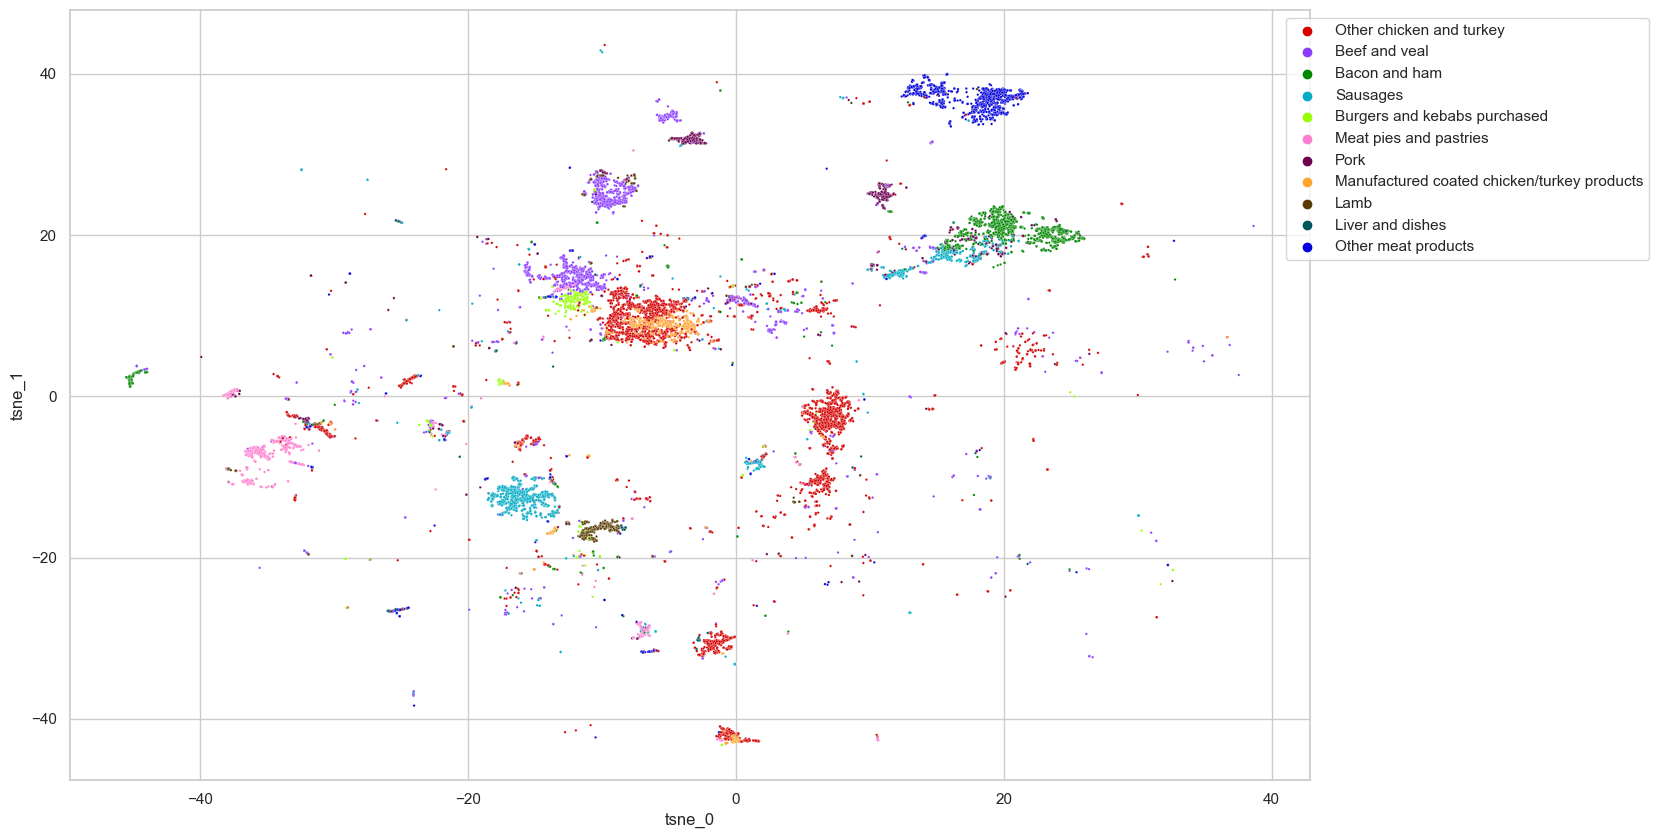

In [33]:
sns.set_style('whitegrid')
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pred['tsne_0'], y=pred['tsne_1'],
    hue=pred['subfoodgroup_pred'],
    palette=sns.color_palette(cc.glasbey, n_colors=pred['subfoodgroup_pred'].nunique()), s=3
)
plt.legend(bbox_to_anchor=(1.28, 1), loc='upper right')

In [34]:
# save level 2 cereal categories
pred.to_csv('../../SFS/NDNS UK/predictions/predictions_meat_lev2_manuallabels_nonHI_RF_15Oct2024.csv', 
                      index=False)